# DL(w10) AE
student ID: 7110018036\
name: Chieh-An, Chou

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl

2023-05-10 14:14:08.784349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Stacked Autoencoders

## Data

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(x_train_set, y_train_set), (x_test, y_test) = fashion_mnist.load_data()

x_train_set = x_train_set/255.0
x_test = x_test/255.0

In [3]:
# (check data)
x_train_set.shape, y_train_set.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

0


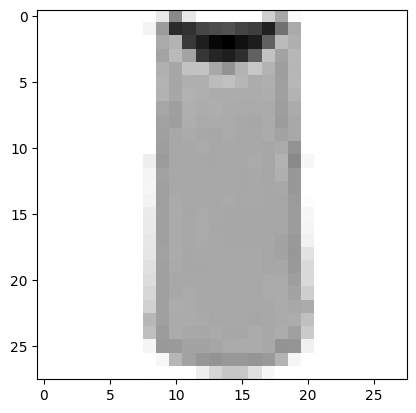

In [4]:
i = 2
print(y_train_set[i])
plt.imshow(x_train_set[i], cmap='binary')
plt.show()

In [5]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_set, y_train_set, random_state = 1)

## Convolutional Autoencoder

### 1. Build Model

In [6]:
np.random.seed(1)
tf.random.set_seed(1)

In [7]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1],input_shape=[28, 28]), # add dimension of channel 
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'), 
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPooling2D(pool_size=2),
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', 
                                 activation='selu', input_shape = [3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    keras.layers.Reshape([28,28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

2023-05-10 11:21:43.016593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 11:21:43.038686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 11:21:43.038778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 11:21:43.039095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

+ Convolution: $\text{Output}_c = floor(\dfrac{\text{Input}-k+2p}{s}+1)$

+ Pooling: $\text{Output}_p = \begin{cases}floor(\dfrac{\text{Input}-k}{s}+1)& \text{, if padding = 'valid'} \\ floor(\dfrac{\text{Input}-1}{s}+1)& \text{, if padding = 'same'} \end{cases}$


In [8]:
conv_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          1

+ Transposed Convolution: (default - `output_padding = 'None'`) \
$\text{Output}_tc = \begin{cases}s\times\text{Input}+\max(k-s,0)& \text{, if padding = 'valid'} \\ s\times\text{Input}& \text{, if padding = 'same'} \end{cases}$

In [9]:
conv_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 7, 7, 32)         18464     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 16)       4624      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        145       
 ranspose)                                                       
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
__________________________________________________

In [10]:
conv_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3, 3, 64)          23296     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            23233     
                                                                 
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


### 2. Compile

In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred)) # 0~1 -> 0,1
conv_ae.compile(loss='binary_crossentropy',   # pixel-by-pixel compare original and reconstructed images
                optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])

### 3. Train 

In [12]:
train = conv_ae.fit(x_train, x_train, epochs=20, validation_data=(x_valid, x_valid))

Epoch 1/20


2023-05-10 11:21:45.541503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2023-05-10 11:21:48.125980: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f57940a1fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-10 11:21:48.125997: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-05-10 11:21:48.155969: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 [==============================] - 17s 9ms/step - loss: 0.3061 - rounded_accuracy: 0.9158 - val_loss: 0.2814 - val_rounded_accuracy: 0.9347
Epoch 2/20
1407/1407 [==============================] - 9s 7ms/step - loss: 0.2778 - rounded_accuracy: 0.9398 - val_loss: 0.2734 - val_rounded_accuracy: 0.9450
Epoch 3/20
1407/1407 [==============================] - 15s 11ms/step - loss: 0.2730 - rounded_accuracy: 0.9446 - val_loss: 0.2700 - val_rounded_accuracy: 0.9472
Epoch 4/20
1407/1407 [==============================] - 15s 10ms/step - loss: 0.2704 - rounded_accuracy: 0.9472 - val_loss: 0.2684 - val_rounded_accuracy: 0.9477
Epoch 5/20
1407/1407 [==============================] - 14s 10ms/step - loss: 0.2686 - rounded_accuracy: 0.9490 - val_loss: 0.2734 - val_rounded_accuracy: 0.9444
Epoch 6/20
1407/1407 [==============================] - 9s 7ms/step - loss: 0.2674 - rounded_accuracy: 0.9504 - val_loss: 0.2651 - val_rounded_accuracy: 0.9516
Epoch 7/20
1407/1407 [======================

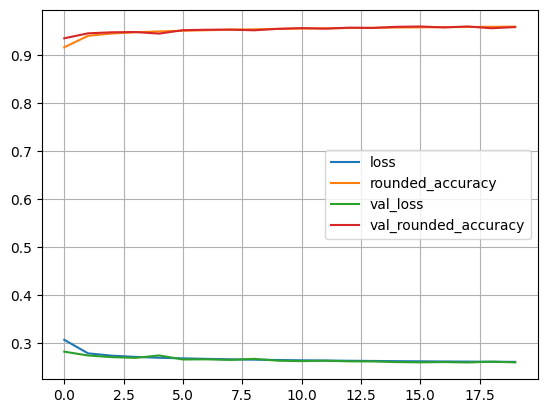

In [13]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()

### 4. Evaluate

In [14]:
conv_ae.evaluate(x_test, x_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2623 - rounded_accuracy: 0.9567


[0.26226291060447693, 0.956696629524231]

### 5. Predict (Reconstruct)

In [15]:
x_test_decoded = conv_ae.predict(x_test)

313/313 [==============================] - 0s 1ms/step


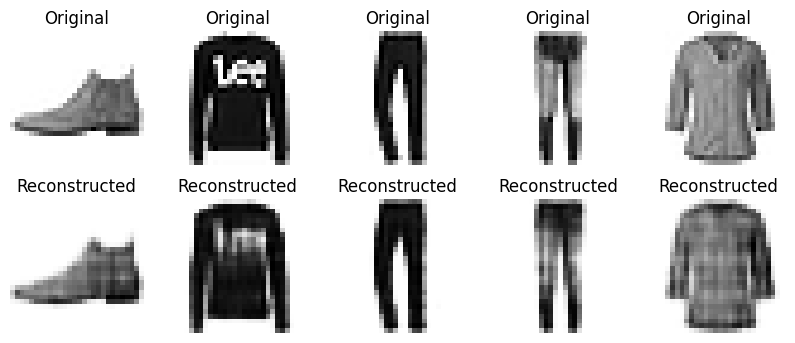

In [16]:
plt.figure(figsize=(10, 4))

for i in range(5):
    plt.subplot(2, 5, 1 + i)
    plt.imshow(x_test[i], cmap='binary')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, 1+ 5 + i)
    plt.imshow(x_test_decoded[i], cmap='binary')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()

### (Checking codings)

In [17]:
x_test_codings = conv_encoder.predict(x_test)
x_test_codings.shape

313/313 [==============================] - 0s 932us/step


(10000, 3, 3, 64)

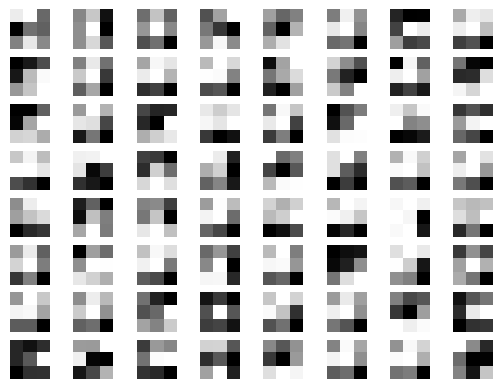

In [18]:
i = 0
for j in range(64):
    plt.subplot(8,8,1+j)
    plt.imshow(x_test_codings[i, :,:,j], cmap='binary')
    plt.axis('off')
plt.show()

## Application: Unsupervised Pretraining

### Data

In [19]:
x_train_lab = x_train[:500]
y_train_lab = y_train[:500]

### Model 1: Classifier without Pretraining
#### 1.1 Build Model

In [20]:
np.random.seed(1)
tf.random.set_seed(1)

In [21]:
clf = keras.models.Sequential([
    keras.layers.Reshape([28,28,1],input_shape=[28, 28]), # add dimension of channel 
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'), 
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPooling2D(pool_size=2),
    # Fully Connected Layers
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])

In [22]:
clf.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)         

#### 1.2 Compile

In [23]:
clf.compile(loss='sparse_categorical_crossentropy',   
            optimizer=keras.optimizers.SGD(learning_rate=.02),
            metrics=['accuracy'])

#### 1.3 Train 

In [24]:
train = clf.fit(x_train_lab, y_train_lab, epochs=30, validation_data=(x_valid, y_valid))

Epoch 1/30
 1/16 [>.............................] - ETA: 7s - loss: 2.3311 - accuracy: 0.0625

2023-05-10 11:32:38.844796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 [==============================] - 1s 50ms/step - loss: 2.0933 - accuracy: 0.2940 - val_loss: 1.8657 - val_accuracy: 0.4161
Epoch 2/30
16/16 [==============================] - 1s 41ms/step - loss: 1.6138 - accuracy: 0.5620 - val_loss: 1.3938 - val_accuracy: 0.5621
Epoch 3/30
16/16 [==============================] - 1s 41ms/step - loss: 1.2520 - accuracy: 0.6120 - val_loss: 1.1369 - val_accuracy: 0.6492
Epoch 4/30
16/16 [==============================] - 1s 42ms/step - loss: 1.0362 - accuracy: 0.6460 - val_loss: 1.1664 - val_accuracy: 0.5669
Epoch 5/30
16/16 [==============================] - 1s 40ms/step - loss: 0.9206 - accuracy: 0.6900 - val_loss: 0.9118 - val_accuracy: 0.6849
Epoch 6/30
16/16 [==============================] - 1s 41ms/step - loss: 0.8714 - accuracy: 0.7120 - val_loss: 0.8826 - val_accuracy: 0.6843
Epoch 7/30
16/16 [==============================] - 1s 47ms/step - loss: 0.7731 - accuracy: 0.7400 - val_loss: 0.8366 - val_accuracy: 0.6989
Epoch 8/30
16/16 [======

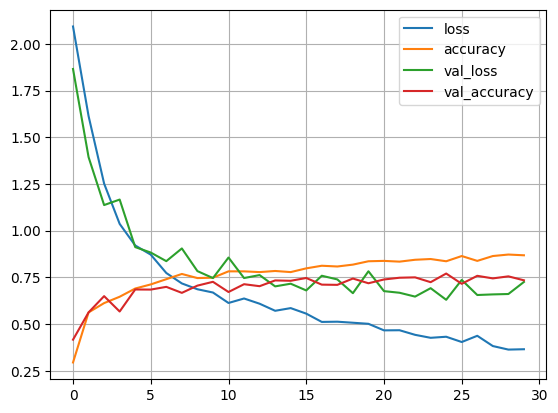

In [25]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()

#### 1.4 Evaluate

In [27]:
clf.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.7414 - accuracy: 0.7329


[0.7413964867591858, 0.7329000234603882]

#### 1.5 Predict

In [28]:
y_prob = clf.predict(x_test)
print("y_prob = ", y_prob[:3].round(2), sep="\n")
y_pred = np.argmax(y_prob,axis=1)
print("y_pred = ", y_pred[:3])
print("y_true = ", y_test[:3].T)

313/313 [==============================] - 0s 1ms/step
y_prob = 
[[0.   0.   0.   0.   0.   0.16 0.   0.7  0.   0.14]
 [0.   0.02 0.58 0.   0.32 0.   0.07 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
y_pred =  [7 2 1]
y_true =  [9 2 1]


### Model 2: Classifier with Unsupervised Pretraining
#### 2.1 Build Model

In [29]:
np.random.seed(1)
tf.random.set_seed(1)

In [30]:
conv_encoder_clone = keras.models.clone_model(conv_encoder)
conv_encoder_clone.set_weights(conv_encoder.get_weights())

In [31]:
pre_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])

In [32]:
pre_clf.summary(show_trainable=True)

Model: "sequential_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential (Sequential)     (None, 3, 3, 64)          23296     Y          
                                                                            
 flatten_1 (Flatten)         (None, 576)               0         Y          
                                                                            
 dense_2 (Dense)             (None, 20)                11540     Y          
                                                                            
 dense_3 (Dense)             (None, 10)                210       Y          
                                                                            
Total params: 35,046
Trainable params: 35,046
Non-trainable params: 0
____________________________________________________________________________


#### 2.2 Compile

In [33]:
pre_clf.compile(loss='sparse_categorical_crossentropy',  
            optimizer=keras.optimizers.SGD(learning_rate=.02),
            metrics=['accuracy'])

#### 2.3 Train 
##### 2.3.1 Train (Phase I): Clone Encoder -> not trainable 

In [34]:
conv_encoder_clone.trainable = False
pre_clf.summary(show_trainable=True)

Model: "sequential_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential (Sequential)     (None, 3, 3, 64)          23296     N          
                                                                            
 flatten_1 (Flatten)         (None, 576)               0         Y          
                                                                            
 dense_2 (Dense)             (None, 20)                11540     Y          
                                                                            
 dense_3 (Dense)             (None, 10)                210       Y          
                                                                            
Total params: 35,046
Trainable params: 11,750
Non-trainable params: 23,296
____________________________________________________________________________


In [35]:
train1 = pre_clf.fit(x_train_lab, y_train_lab, epochs=15, validation_data=(x_valid, y_valid))

Epoch 1/15
16/16 [==============================] - 1s 56ms/step - loss: 2.7992 - accuracy: 0.2880 - val_loss: 1.6338 - val_accuracy: 0.4513
Epoch 2/15
16/16 [==============================] - 1s 38ms/step - loss: 1.0855 - accuracy: 0.6260 - val_loss: 0.9407 - val_accuracy: 0.6643
Epoch 3/15
16/16 [==============================] - 1s 42ms/step - loss: 0.9310 - accuracy: 0.6640 - val_loss: 0.8589 - val_accuracy: 0.7002
Epoch 4/15
16/16 [==============================] - 1s 70ms/step - loss: 0.6821 - accuracy: 0.7540 - val_loss: 0.7738 - val_accuracy: 0.7247
Epoch 5/15
16/16 [==============================] - 1s 63ms/step - loss: 0.6105 - accuracy: 0.7700 - val_loss: 0.9246 - val_accuracy: 0.6815
Epoch 6/15
16/16 [==============================] - 1s 57ms/step - loss: 0.5858 - accuracy: 0.7900 - val_loss: 0.7388 - val_accuracy: 0.7245
Epoch 7/15
16/16 [==============================] - 1s 52ms/step - loss: 0.5160 - accuracy: 0.8080 - val_loss: 0.7045 - val_accuracy: 0.7448
Epoch 8/15
16

##### 2.3.2 Train (Phase I): Clone Encoder -> trainable 

In [36]:
conv_encoder_clone.trainable = True
pre_clf.summary(show_trainable=True)

Model: "sequential_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential (Sequential)     (None, 3, 3, 64)          23296     Y          
                                                                            
 flatten_1 (Flatten)         (None, 576)               0         Y          
                                                                            
 dense_2 (Dense)             (None, 20)                11540     Y          
                                                                            
 dense_3 (Dense)             (None, 10)                210       Y          
                                                                            
Total params: 35,046
Trainable params: 35,046
Non-trainable params: 0
____________________________________________________________________________


In [37]:
train2 = pre_clf.fit(x_train_lab, y_train_lab, epochs=15, validation_data=(x_valid, y_valid))

Epoch 1/15
16/16 [==============================] - 1s 43ms/step - loss: 0.3251 - accuracy: 0.8760 - val_loss: 0.7291 - val_accuracy: 0.7341
Epoch 2/15
16/16 [==============================] - 1s 43ms/step - loss: 0.2837 - accuracy: 0.9040 - val_loss: 0.6530 - val_accuracy: 0.7610
Epoch 3/15
16/16 [==============================] - 1s 54ms/step - loss: 0.2955 - accuracy: 0.8940 - val_loss: 0.6813 - val_accuracy: 0.7575
Epoch 4/15
16/16 [==============================] - 1s 40ms/step - loss: 0.2686 - accuracy: 0.9040 - val_loss: 0.6540 - val_accuracy: 0.7742
Epoch 5/15
16/16 [==============================] - 1s 49ms/step - loss: 0.2615 - accuracy: 0.9060 - val_loss: 0.6730 - val_accuracy: 0.7738
Epoch 6/15
16/16 [==============================] - 1s 40ms/step - loss: 0.2561 - accuracy: 0.9100 - val_loss: 0.7125 - val_accuracy: 0.7539
Epoch 7/15
16/16 [==============================] - 1s 37ms/step - loss: 0.2308 - accuracy: 0.9240 - val_loss: 0.6366 - val_accuracy: 0.7795
Epoch 8/15
16

#### 2.4 Evaluate

In [38]:
pre_clf.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.7071 - accuracy: 0.7778


[0.7070891857147217, 0.7778000235557556]

#### 2.5 Predict

In [39]:
y_prob = pre_clf.predict(x_test)
print("y_prob = ", y_prob[:3].round(2), sep="\n")
y_pred = np.argmax(y_prob,axis=1)
print("y_pred = ", y_pred[:3])
print("y_true = ", y_test[:3].T)

313/313 [==============================] - 0s 1ms/step
y_prob = 
[[0.   0.   0.   0.   0.   0.04 0.   0.52 0.04 0.41]
 [0.01 0.   0.93 0.   0.04 0.   0.02 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
y_pred =  [7 2 1]
y_true =  [9 2 1]


## Data

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(x_train_set, y_train_set), (x_test, y_test) = fashion_mnist.load_data()

x_train_set = x_train_set/255.0
x_test = x_test/255.0

In [3]:
# (check data)
x_train_set.shape, y_train_set.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

3


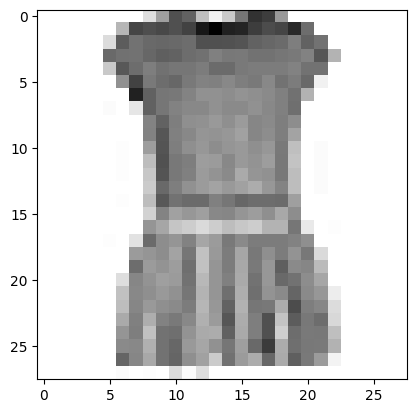

In [4]:
i = 3
print(y_train_set[i])
plt.imshow(x_train_set[i], cmap='binary')
plt.show()

In [5]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_set, y_train_set, random_state = 1)

## Recurrent Autoencoder

### 1. Build Model

In [6]:
np.random.seed(1)
tf.random.set_seed(1)

In [7]:
re_encoder = keras.models.Sequential([                                      # (28,28): (time_steps, dim)
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28,28]),     # (28, 100)
    keras.layers.LSTM(30),                                                  # (30)
])
re_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),                            # (28, 30)
    keras.layers.LSTM(100, return_sequences=True),                              # (28, 100)
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))  # (28,28)
])
re_ae = keras.models.Sequential([re_encoder, re_decoder])

2023-05-10 13:44:10.052394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 13:44:10.071721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 13:44:10.071822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 13:44:10.072240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [8]:
re_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 100)           51600     
                                                                 
 lstm_1 (LSTM)               (None, 30)                15720     
                                                                 
Total params: 67,320
Trainable params: 67,320
Non-trainable params: 0
_________________________________________________________________


In [9]:
re_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVector  (None, 28, 30)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 28, 100)           52400     
                                                                 
 time_distributed (TimeDistr  (None, 28, 28)           2828      
 ibuted)                                                         
                                                                 
Total params: 55,228
Trainable params: 55,228
Non-trainable params: 0
_________________________________________________________________


In [10]:
re_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                67320     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            55228     
                                                                 
Total params: 122,548
Trainable params: 122,548
Non-trainable params: 0
_________________________________________________________________


### 2. Compile

In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred)) # 0~1 -> 0,1
re_ae.compile(loss='binary_crossentropy',   # pixel-by-pixel compare original and reconstructed images
                optimizer=keras.optimizers.SGD(learning_rate=.15),
                metrics=[rounded_accuracy])

### 3. Train 

In [12]:
train = re_ae.fit(x_train, x_train, epochs=20, validation_data=(x_valid, x_valid))

Epoch 1/20


2023-05-10 13:44:22.980544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2023-05-10 13:44:23.094996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-10 13:44:23.097134: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2afc12da50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-10 13:44:23.097145: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-05-10 13:44:23.130478: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 [==============================] - 23s 14ms/step - loss: 0.4897 - rounded_accuracy: 0.7881 - val_loss: 0.4262 - val_rounded_accuracy: 0.8165
Epoch 2/20
1407/1407 [==============================] - 25s 18ms/step - loss: 0.3842 - rounded_accuracy: 0.8547 - val_loss: 0.3622 - val_rounded_accuracy: 0.8749
Epoch 3/20
1407/1407 [==============================] - 23s 16ms/step - loss: 0.3563 - rounded_accuracy: 0.8770 - val_loss: 0.3524 - val_rounded_accuracy: 0.8752
Epoch 4/20
1407/1407 [==============================] - 24s 17ms/step - loss: 0.3427 - rounded_accuracy: 0.8865 - val_loss: 0.3340 - val_rounded_accuracy: 0.8951
Epoch 5/20
1407/1407 [==============================] - 24s 17ms/step - loss: 0.3342 - rounded_accuracy: 0.8921 - val_loss: 0.3316 - val_rounded_accuracy: 0.8958
Epoch 6/20
1407/1407 [==============================] - 18s 13ms/step - loss: 0.3284 - rounded_accuracy: 0.8961 - val_loss: 0.3281 - val_rounded_accuracy: 0.8959
Epoch 7/20
1407/1407 [=================

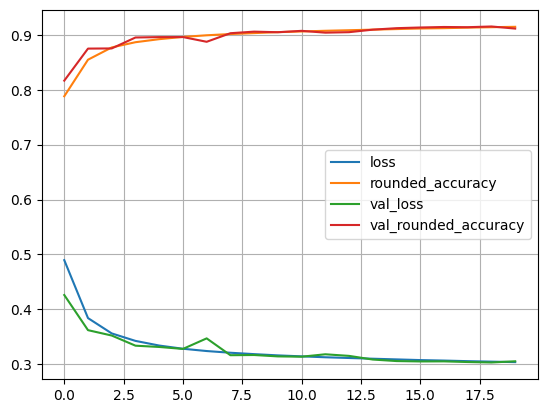

In [13]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()

### 4. Evaluate

In [14]:
re_ae.evaluate(x_test, x_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3086 - rounded_accuracy: 0.9097


[0.30862945318222046, 0.9097490906715393]

### 5. Predict (Reconstruct)

In [15]:
x_test_decoded = re_ae.predict(x_test)

313/313 [==============================] - 1s 2ms/step


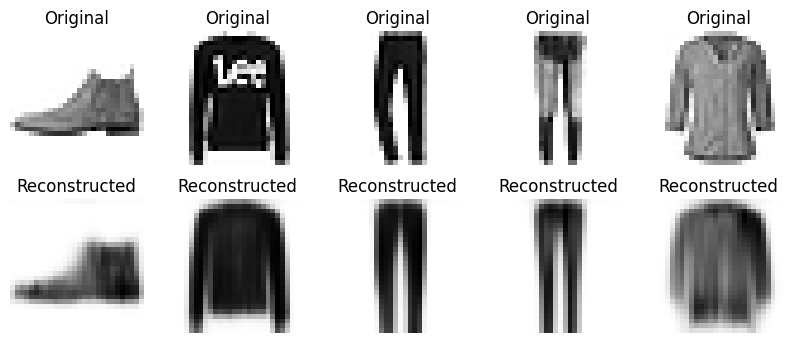

In [16]:
plt.figure(figsize=(10, 4))

for i in range(5):
    plt.subplot(2, 5, 1 + i)
    plt.imshow(x_test[i], cmap='binary')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, 1+ 5 + i)
    plt.imshow(x_test_decoded[i], cmap='binary')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()

### (Checking codings)

In [17]:
x_test_codings = re_encoder.predict(x_test)
x_test_codings.shape

313/313 [==============================] - 1s 1ms/step


(10000, 30)

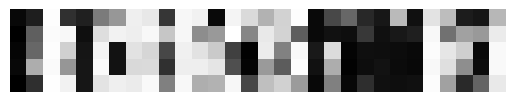

In [18]:
i=range(5)
plt.imshow(x_test_codings[i], cmap='binary')
plt.axis('off')
plt.show()

# Stacked Denoising Autoencoders

## Data

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(x_train_set, y_train_set), (x_test, y_test) = fashion_mnist.load_data()

x_train_set = x_train_set/255.0
x_test = x_test/255.0

In [3]:
# (check data)
x_train_set.shape, y_train_set.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

0


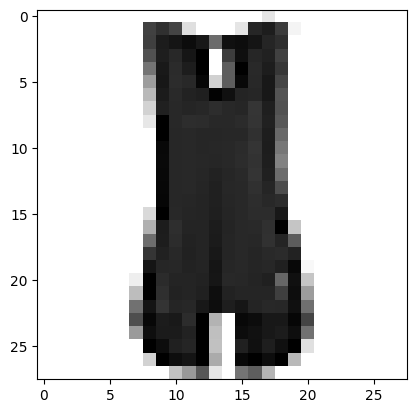

In [4]:
i = 4
print(y_train_set[i])
plt.imshow(x_train_set[i], cmap='binary')
plt.show()

In [5]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_set, y_train_set, random_state = 1)

## Method 1: Add Gaussian Noise
#### 1.1 Build Model

In [6]:
np.random.seed(1)
tf.random.set_seed(1)

In [7]:
gaus_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.GaussianNoise(stddev=.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
gaus_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]), 
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])
gaus_ae = keras.models.Sequential([gaus_encoder, gaus_decoder])

2023-05-10 14:14:18.090150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 14:14:18.108874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 14:14:18.108959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 14:14:18.109625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [8]:
gaus_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 784)              0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [9]:
gaus_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 784)               79184     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


In [10]:
gaus_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                81530     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            82284     
                                                                 
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


#### 1.2 Compile

In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred)) # 0~1 -> 0,1
gaus_ae.compile( loss='binary_crossentropy', 
               optimizer=keras.optimizers.SGD(learning_rate=1.0),
               metrics=[rounded_accuracy])

#### 1.3 Train 

In [12]:
train = gaus_ae.fit(x_train, x_train, epochs=10, validation_data=(x_valid, x_valid))

Epoch 1/10
   1/1407 [..............................] - ETA: 25:41 - loss: 0.7074 - rounded_accuracy: 0.4964

2023-05-10 14:14:27.203808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-10 14:14:27.206377: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55b284c737f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-10 14:14:27.206389: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-05-10 14:14:27.239034: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 [==============================] - 9s 5ms/step - loss: 0.3556 - rounded_accuracy: 0.8725 - val_loss: 0.3189 - val_rounded_accuracy: 0.9030
Epoch 2/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3159 - rounded_accuracy: 0.9069 - val_loss: 0.3092 - val_rounded_accuracy: 0.9121
Epoch 3/10
1407/1407 [==============================] - 4s 3ms/step - loss: 0.3083 - rounded_accuracy: 0.9133 - val_loss: 0.3025 - val_rounded_accuracy: 0.9167
Epoch 4/10
1407/1407 [==============================] - 5s 3ms/step - loss: 0.3041 - rounded_accuracy: 0.9168 - val_loss: 0.3029 - val_rounded_accuracy: 0.9196
Epoch 5/10
1407/1407 [==============================] - 4s 3ms/step - loss: 0.3015 - rounded_accuracy: 0.9191 - val_loss: 0.2987 - val_rounded_accuracy: 0.9186
Epoch 6/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2993 - rounded_accuracy: 0.9210 - val_loss: 0.2955 - val_rounded_accuracy: 0.9235
Epoch 7/10
1407/1407 [=============================

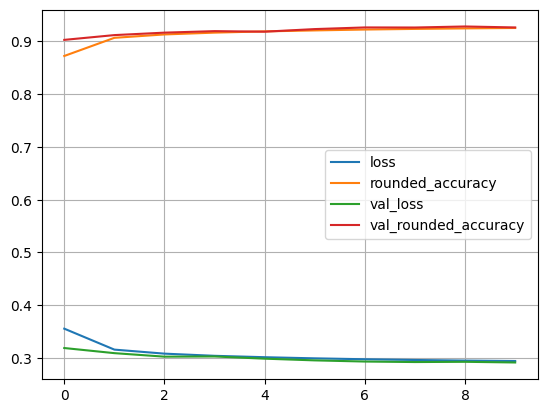

In [13]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()

#### 1.4 Evaluate

In [14]:
np.random.seed(1)
tf.random.set_seed(1)

noise = keras.layers.GaussianNoise(.2)
x_test_noise = noise(x_test, training = True)

In [15]:
gaus_ae.evaluate(x_test_noise, x_test) # noised (-> denoised) vs original 

313/313 [==============================] - 0s 1ms/step - loss: 0.2973 - rounded_accuracy: 0.9220


[0.29730913043022156, 0.9220280647277832]

#### 1.5 Predict (Denoising)

In [16]:
x_test_decoded = gaus_ae.predict(x_test_noise)

313/313 [==============================] - 0s 741us/step


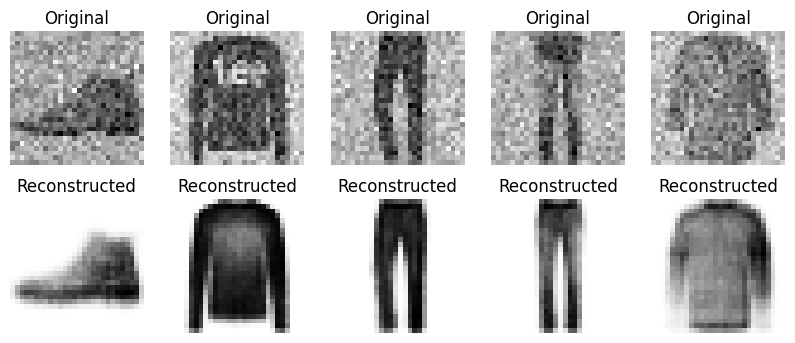

In [17]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, 1 + i)
    plt.imshow(x_test_noise[i], cmap='binary')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, 1+ 5 + i)
    plt.imshow(x_test_decoded[i], cmap='binary')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()

## Model 2: Using Dropout
#### 2.1 Build Model

In [18]:
np.random.seed(1)
tf.random.set_seed(1)

In [19]:
drop_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dropout(rate=.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
drop_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]), 
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])
drop_ae = keras.models.Sequential([drop_encoder, drop_decoder])

In [20]:
drop_encoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [21]:
drop_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               3100      
                                                                 
 dense_7 (Dense)             (None, 784)               79184     
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


In [22]:
drop_ae.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 30)                81530     
                                                                 
 sequential_4 (Sequential)   (None, 28, 28)            82284     
                                                                 
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


#### 2.2 Compile

In [24]:
drop_ae.compile(loss='binary_crossentropy',  
                optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])

#### 2.3 Train 

In [25]:
train = drop_ae.fit(x_train, x_train, epochs=10, validation_data=(x_valid, x_valid))

Epoch 1/10
1407/1407 [==============================] - 4s 2ms/step - loss: 0.3631 - rounded_accuracy: 0.8658 - val_loss: 0.3239 - val_rounded_accuracy: 0.8978
Epoch 2/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3221 - rounded_accuracy: 0.9002 - val_loss: 0.3142 - val_rounded_accuracy: 0.9048
Epoch 3/10
1407/1407 [==============================] - 4s 3ms/step - loss: 0.3159 - rounded_accuracy: 0.9050 - val_loss: 0.3084 - val_rounded_accuracy: 0.9122
Epoch 4/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3116 - rounded_accuracy: 0.9086 - val_loss: 0.3065 - val_rounded_accuracy: 0.9108
Epoch 5/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3088 - rounded_accuracy: 0.9109 - val_loss: 0.3097 - val_rounded_accuracy: 0.9030
Epoch 6/10
1407/1407 [==============================] - 4s 3ms/step - loss: 0.3069 - rounded_accuracy: 0.9124 - val_loss: 0.3016 - val_rounded_accuracy: 0.9151
Epoch 7/10
1407/1407 [==================

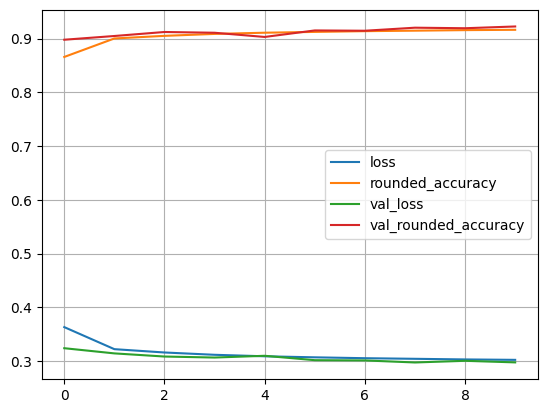

In [26]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()

#### 2.4 Evaluate

In [27]:
np.random.seed(1)
tf.random.set_seed(1)

dropout = keras.layers.Dropout(.5)
x_test_dropout = dropout(x_test, training = True)

In [28]:
drop_ae.evaluate(x_test_dropout, x_test) 

313/313 [==============================] - 0s 1ms/step - loss: 0.3058 - rounded_accuracy: 0.9157


[0.30579277873039246, 0.9156724810600281]

#### 2.5 Predict (Denoising)

In [29]:
x_test_decoded = drop_ae.predict(x_test_dropout)

313/313 [==============================] - 0s 835us/step


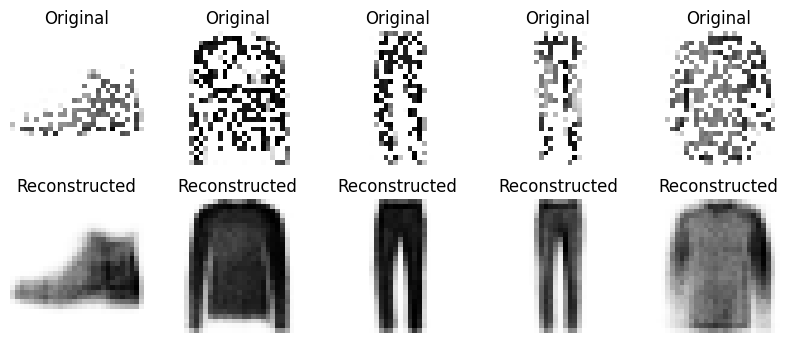

In [31]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, 1 + i)
    plt.imshow(x_test_dropout[i], cmap='binary')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, 1+ 5 + i)
    plt.imshow(x_test_decoded[i], cmap='binary')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()